In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import spline, interp1d
from scipy.optimize import fsolve

ImportError: cannot import name 'spline' from 'scipy.interpolate' (c:\users\canderson\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\__init__.py)

In [2]:
# fully open gate height estimated from diagram on source 4
print('Gate dimensions at "empty" dam (30m) and fully open gate:')
GateHeight = (503-476)/2
print('   Gate Height =',round(GateHeight,2),'m')
GateFlowArea = 3.84405**2 # m^2 so that flow rate maxes at 358.5 m^3/s
GateWidth = GateFlowArea/GateHeight
print('   Gate Width =',round(GateWidth,4),'m')
def FlowRate(h,Δz):
    # h  = height of opening of the gate valve
    # Δz = dam depth can range from 30 to 220 m
    # returns the flow rate (q)
    width = GateWidth #m
    A = h*width
    g = 9.81 # m/s^2
    v = np.sqrt(2*g*Δz) # m/s - velocity of water
    q = A*v # flow rate through gate maxes at 358.5 m^3/s
    return q
print('   Max Flow rate =',round(FlowRate(13.5,30),2),'m^3/s')

Gate dimensions at "empty" dam (30m) and fully open gate:
   Gate Height = 13.5 m
   Gate Width = 1.0946 m
   Max Flow rate = 358.5 m^3/s


In [3]:
def PowerOut(h,Δz):
    # This function give the power output given the height of the
    #     gate's opening, and depth of the dam
    # returns power output in MW
    
    q = FlowRate(h,Δz)
    g = 9.81 # m/s^2
    
    # efficiency found using max rated flowrate (358.5 m^3/s)
    # and rated output (640 MW)
    η = .8286
    
    ρ = 998.29 # kg/m^3 - density of water at 20°C
    W_dam = ρ*g*q*Δz # Energy from dam hydrostatic pressure
    W_head = 0#ρ*g*q*194 # Energy from 194 m head between gate and turbine
    return η*(W_dam+W_head) / 10**6

print('At maximum gate opening and "empty" dam (30m):')
print('   Max power output =',round(PowerOut(13.5,30),2),'MW')

At maximum gate opening and "empty" dam (30m):
   Max power output = 87.27 MW


In [4]:
def FindOperatingHeights(Δz):
    # Need to change the gate height depending on the Dam Level
    #   in order to maintain within operating zones for turbine
    
    def HiMx(h):
        return PowerOut(h,Δz)-640.0
    HighMax = fsolve(HiMx,8)[0]
    if HighMax > 13.5:
        HighMax = 13.5
    if HighMax < 0.0:
        HighMax = 0.0
    #print(HighMax)

    def HiLo(h):
        return PowerOut(h,Δz)-550.0
    HighLow = fsolve(HiLo,8)[0]
    if HighLow > 13.5:
        HighLow = 13.5
    if HighLow < 0:
        HighLow = 0.0
    #print(HighLow)

    def LoMx(h):
        return PowerOut(h,Δz)-350.0
    LowMax = fsolve(LoMx,3)[0]
    if LowMax > 13.5:
        LowMax = 13.5
    if LowMax < 0:
        LowMax = 0.0
    #print(LowMax)

    def LoLo(h):
        return PowerOut(h,Δz)-0.0
    LowLow = fsolve(LoLo,3)[0]
    if LowLow > 13.5:
        LowLow = 13.5
    if LowLow < 0:
        LowLow = 0.0
    #print(LowLow)
    
    return [HighMax,HighLow,LowMax,LowLow]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


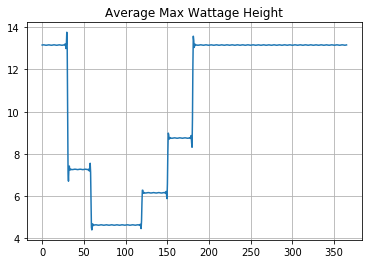

In [15]:
# Step function of dam level
ndays = 365
#DamLevel = np.array([106,163,220,220,182,144,106,68,30,30,68,106])
DamLevel = np.ones(ndays+1)
DamLevel[0:31] *= 106
DamLevel[31:59] *= 163
DamLevel[59:90] *= 220
DamLevel[90:120] *= 220
DamLevel[120:151] *= 182
DamLevel[151:181] *= 144
DamLevel[181:212] *= 106
DamLevel[212:243] *= 68
DamLevel[243:273] *= 30
DamLevel[273:304] *= 30
DamLevel[304:334] *= 68
DamLevel[334:366] *= 106

# Find Operating Limits to graph
TopMax = np.ones(len(DamLevel))
TopLow = np.ones(len(DamLevel))
BotMax = np.ones(len(DamLevel))
BotLow = np.ones(len(DamLevel))
for i in range(len(DamLevel)):
    #print(i)
    z = DamLevel[i]
    values = FindOperatingHeights(z)
    TopMax[i] = values[0]
    TopLow[i] = values[1]
    BotMax[i] = values[2]
    BotLow[i] = values[3]

ts = np.linspace(0,ndays,ndays+1) # Each day of the year

#plt.grid()
#plt.title('Safe Operating Height Regimes')
#plt.plot(ts,TopMax,'--b',label='640-550 MW')
#plt.plot(ts,TopLow,'--b')
#plt.fill(np.append(ts, ts[::-1]), np.append(TopMax, TopLow[::-1]), 'b')
#plt.plot(ts,BotMax,'--g',label='0-350 MW')
#plt.plot(ts,BotLow,'--g')
#plt.fill(np.append(ts, ts[::-1]), np.append(BotMax, BotLow[::-1]), 'g')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.show()

#plt.grid()
#plt.title('Dam Level Throughout the year')
#plt.plot(ts,DamLevel,label='Dam Level')
#plt.show()

# Generate simulated process data
avgHeight = (TopMax+TopLow)/2
for i in range (len(TopMax)):
    if avgHeight[i] == TopMax[i]:
        avgHeight[i] = avgHeight[i-1]
tsnew = np.linspace(0,ndays,2*ndays)
newHeightSim = spline(ts,avgHeight,tsnew)
process = newHeightSim + .01*np.sin(tsnew)

plt.grid()
plt.title('Average Max Wattage Height')
plt.plot(tsnew,process)
plt.show()

$$h_{max} = 13.5\ m,\ h_{min} = 0.0\ m$$

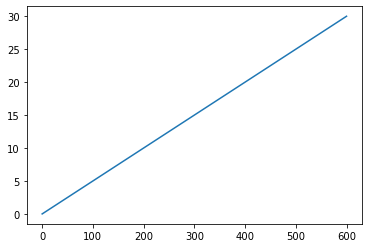

In [4]:
gate_speed = 1./20. #m/s
def gateHChange(y,t):
    return gate_speed

t = np.linspace(0,60*10,200)
tt = np.linspace(0,60*10*3,200*3)
h0 = 0
sol = odeint(gateHChange,h0,t)
plt.plot(t,sol[:,0])
plt.plot(tt[:200],[0])